# Analytics Vidhya Hackathon
Sentiment analysis remains one of the key problems that has seen extensive application of natural language processing. This time around, given the tweets from customers about various tech firms who manufacture and sell mobiles, computers, laptops, etc, the task is to identify if the tweets have a negative sentiment towards such companies or products.

 
Evaluation Metric

The metric used for evaluating the performance of classification model would be weighted F1-Score.

# Data

- train.csv - For training the models, we provide a labelled dataset of 7920 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.

- test.csv - The test data file contains only tweet ids and the tweet text with each tweet in a new line.

- sample_submission.csv - The exact format for a valid submission

Most profane and vulgar terms in the tweets have been replaced with “$&@*#”. However, please note that the dataset still might contain text that may be considered profane, vulgar, or offensive.


In [189]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk 
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_sub.csv')

In [3]:
df_train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [4]:
df_test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [5]:
df_sample.head()

,id,label
0,7921,0
1,7922,0
2,7923,0
3,7924,0
4,7925,0


# Exploratory Data Analysis

In [6]:
print(df_train.shape)
print(df_test.shape)

(7920, 3)
(1953, 2)


In [7]:
sentiment_count = df_train.groupby('label').count()['tweet'].reset_index().sort_values(by=['tweet'], ascending=False)
sentiment_count

,label,tweet
0,0,5894
1,1,2026


<AxesSubplot:xlabel='label', ylabel='count'>

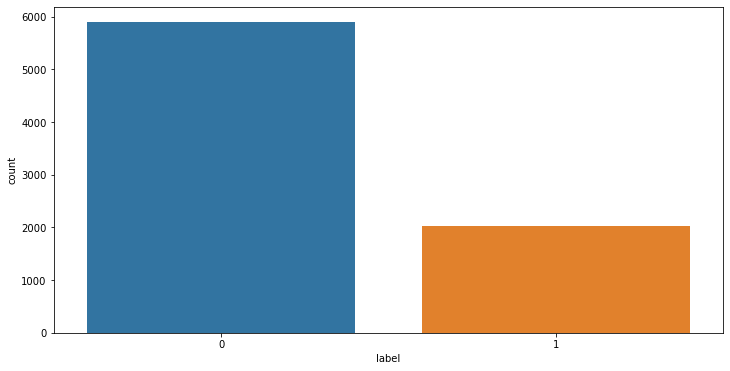

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=df_train)

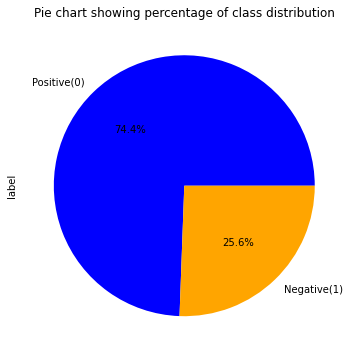

In [9]:

plt.figure(figsize=(12,6))
df_train["label"].value_counts().plot.pie(labels=['Positive(0)', 'Negative(1)'], 
                                                autopct='%.1f%%',
                                                title = 'Pie chart showing percentage of class distribution',
                                                colors = ['blue','orange'])
plt.rc('font', size=20) 
plt.rc('axes', titlesize=20) 
plt.rc('axes', labelsize=20) 
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=20)

# Data Engineering

In [10]:
#Read the entire first line in message column
print(df_train.loc[0, 'tweet'])
print(df_test.loc[0, 'tweet'])

#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks


In [11]:
#Replacing the websites with the text "web-url"
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_train['tweet'] = df_train['tweet'].replace(to_replace = pattern_url, value = subs_url, regex = True)
df_test['tweet'] = df_test['tweet'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [12]:
# To confirm the change
print(df_train.loc[0, 'tweet'])

#fingerprint #Pregnancy Test url-web #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone


In [13]:
#make text to lower case 
df_train['tweet'] = df_train['tweet'].str.lower()
df_test['tweet'] = df_test['tweet'].str.lower()

In [14]:
# To confirm the change
print(df_train.loc[0, 'tweet'])

#fingerprint #pregnancy test url-web #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone


In [15]:
#Remove punctuation
import string
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

df_train['tweet'] = df_train['tweet'].apply(remove_punctuation)
df_test['tweet'] = df_test['tweet'].apply(remove_punctuation)

In [16]:
# To confirm the change
print(df_train.loc[0, 'tweet'])

fingerprint pregnancy test urlweb android apps beautiful cute health igers iphoneonly iphonesia iphone


In [17]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
df_train["tweet"] = df_train["tweet"].apply(lambda text: remove_stopwords(text))
df_train.head()

,id,label,tweet
0,1,0,fingerprint pregnancy test urlweb android apps...
1,2,0,finally transparant silicon case thanks uncle ...
2,3,0,love would go talk makememories unplug relax i...
3,4,0,im wired know im george made way iphone cute d...
4,5,1,amazing service apple wont even talk question ...


In [18]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
df_test["tweet"] = df_test["tweet"].apply(lambda text: remove_stopwords(text))
df_test.head()

,id,tweet
0,7921,hate new iphone upgrade wont let download apps...
1,7922,currently shitting fucking pants apple imac ca...
2,7923,id like puts cdroms ipad possible — yes wouldn...
3,7924,ipod officially dead lost pictures videos 1d 5...
4,7925,fighting itunes night want music paid


In [19]:
from collections import Counter
cnt = Counter()
for text in df_train["tweet"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('urlweb', 4420),
 ('iphone', 3676),
 ('apple', 2836),
 ('samsung', 1383),
 ('new', 1137),
 ('phone', 950),
 ('sony', 818),
 ('follow', 719),
 ('…', 703),
 ('ipad', 509),
 ('love', 423),
 ('like', 423),
 ('life', 415),
 ('android', 409),
 ('rt', 378),
 ('day', 358),
 ('instagram', 345),
 ('cute', 321),
 ('photo', 318),
 ('gain', 310)]

### Preparing our data

In [20]:
vect = CountVectorizer(ngram_range=(1, 2), stop_words = 'english', min_df=2, max_df=0.5,)
vect.fit(df_train['tweet'])

CountVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2), stop_words='english')

# Model 1: Logistic Regression

In [28]:
X_vectorized = vect.fit_transform(df_train['tweet'])

In [23]:
y_train = df_train.label

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_train,
                                                   test_size=0.2,
                                                   shuffle=True,
                                                   stratify= y_train,
                                                   random_state=42)

In [25]:
lg = LogisticRegression(C=1, penalty='l2', solver='liblinear', verbose=1, class_weight='balanced')
lg.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1, class_weight='balanced', solver='liblinear', verbose=1)

In [26]:
lg_preds = lg.predict(X_test)

In [27]:
f1_lg = f1_score(y_test, lg_preds, average='macro')
f1_lg

0.8579932582657963

In [43]:
# ### Getting test data ready
test = df_test['tweet']
test_vect = vect.transform(test)

In [44]:
lg_preds_test = lg.predict(test_vect)

In [48]:
df_test['label'] = lg_preds_test
df_test.head()

,id,tweet,label
0,7921,1,1
1,7922,1,1
2,7923,1,1
3,7924,1,1
4,7925,1,1


# Creating a submission file with the id and label predictions

In [49]:
df_test[['id', 'label']].to_csv('logistic_regression_submission.csv', index=False)

>> ### This 1st submission put me on 519 out of 8513 on the leaderboard

# Model 2: Support Vector Classifier

In [29]:
svc = LinearSVC(class_weight='balanced')

In [30]:
svc.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [31]:
svc_preds = svc.predict(X_test)

In [32]:
f1_svc = f1_score(y_test, svc_preds, average='macro')
f1_svc

0.8203651875357645

# Model 3

In [33]:
svc2 = LinearSVC()

In [34]:
svc2.fit(X_train, y_train)

LinearSVC()

In [35]:
svc_preds2 = svc2.predict(X_test)

In [36]:
f1_svc2 = f1_score(y_test, svc_preds2, average='macro')
f1_svc2

0.8190920338821739

# Model 4: K Nearest Neighbors

In [37]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [38]:
knn_preds = knn.predict(X_test)

In [39]:
f1_knn = f1_score(y_test, knn_preds, average='macro')
f1_knn

0.5530738298431259

# Model 5: Random Forest Classifier

In [40]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
rfc_preds = rfc.predict(X_test)

In [42]:
f1_rfc = f1_score(y_test, rfc_preds, average='macro')
f1_rfc

0.8212778713034965

# Model 6: SVC

In [97]:
svc3 = SVC(gamma='auto')

In [98]:
svc3.fit(X_train, y_train)

SVC(gamma='auto')

In [99]:
svc3_preds = svc3.predict(X_test)

In [100]:
f1_svc3 = f1_score(y_test, svc3_preds, average='macro')
f1_svc3

0.42671009771986973

# Model 6: Voting Classifier

In [109]:
# group / ensemble of models
estimator = []
estimator.append(('LR', LogisticRegression(C=1,penalty='l2',solver='liblinear',verbose=1,class_weight='balanced')))
estimator.append(('SVC',LinearSVC(class_weight='balanced')))
estimator.append(('RFC',RandomForestClassifier(n_estimators=100,random_state=42)))
#estimator.append(('KNN',KNeighborsClassifier(n_neighbors=5)))
#estimator.append(('SVC3',SVC(gamma='auto')))


# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)

[LibLinear]

In [110]:
f1_vot = f1_score(y_test, y_pred, average='macro')
f1_vot

0.8502611385651662

In [81]:
vot_preds_test = vot_hard.predict(test_vect)

In [82]:
df_test['label'] = vot_preds_test
df_test.head()

,id,tweet,label
0,7921,1,1
1,7922,1,1
2,7923,1,1
3,7924,1,1
4,7925,1,1


In [83]:
df_test[['id', 'label']].to_csv('voting_classifier.csv', index=False)

# Model 7: Stacking Classifier

In [119]:
level0 = list()
level0.append(('lr', LogisticRegression(C=1, penalty='l2', solver='liblinear', verbose=1, class_weight='balanced')))
#level0.append(('knn', KNeighborsClassifier()))
level0.append(('RFC',RandomForestClassifier(n_estimators=100,random_state=42)))
level0.append(('svm', LinearSVC(class_weight='balanced')))
#level0.append(('bayes', GaussianNB()))

# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)

In [120]:
model.fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear]

StackingClassifier(cv=3,
                   estimators=[('lr',
                                LogisticRegression(C=1, class_weight='balanced',
                                                   solver='liblinear',
                                                   verbose=1)),
                               ('RFC', RandomForestClassifier(random_state=42)),
                               ('svm', LinearSVC(class_weight='balanced'))],
                   final_estimator=LogisticRegression())

In [121]:
y_pred_stacking = model.predict(X_test)

In [122]:
f1_stacking = f1_score(y_test, y_pred_stacking, average='macro')
f1_stacking

0.8583226001969847

# Try 2

In [123]:
level0 = list()
level0.append(('lr', LogisticRegression(C=1, penalty='l2', solver='liblinear', verbose=1, class_weight='balanced')))
#level0.append(('knn', KNeighborsClassifier()))
level0.append(('RFC',RandomForestClassifier(n_estimators=100,random_state=42)))
level0.append(('svm', LinearSVC(class_weight='balanced')))
#level0.append(('bayes', GaussianNB()))

# define meta learner model
level1 = LogisticRegression(C=1, penalty='l2', solver='liblinear', verbose=1, class_weight='balanced')
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)

In [124]:
model.fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

StackingClassifier(cv=3,
                   estimators=[('lr',
                                LogisticRegression(C=1, class_weight='balanced',
                                                   solver='liblinear',
                                                   verbose=1)),
                               ('RFC', RandomForestClassifier(random_state=42)),
                               ('svm', LinearSVC(class_weight='balanced'))],
                   final_estimator=LogisticRegression(C=1,
                                                      class_weight='balanced',
                                                      solver='liblinear',
                                                      verbose=1))

In [125]:
y_pred_stacking = model.predict(X_test)

In [126]:
f1_stacking = f1_score(y_test, y_pred_stacking, average='macro')
f1_stacking

0.8622377185027674

In [127]:
stacking_preds_test = model.predict(test_vect)

In [128]:
df_test['label'] = stacking_preds_test
df_test.head()

,id,tweet,label
0,7921,1,1
1,7922,1,1
2,7923,1,1
3,7924,1,1
4,7925,1,1


In [129]:
df_test[['id', 'label']].to_csv('stacking_classifier.csv', index=False)

> ### The above took me to position 500 out of 1394 on the leaderboard

# Try 3

In [134]:
level0 = list()
level0.append(('lr', LogisticRegression(C=1, penalty='l2', solver='liblinear', verbose=1, class_weight='balanced')))
#level0.append(('knn', KNeighborsClassifier()))
level0.append(('RFC',RandomForestClassifier(n_estimators=100,random_state=42)))
level0.append(('svm', LinearSVC(class_weight='balanced')))
#level0.append(('bayes', GaussianNB()))

# define meta learner model
level1 = RandomForestClassifier(n_estimators=100,random_state=42)
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)

In [135]:
model.fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear]

StackingClassifier(cv=3,
                   estimators=[('lr',
                                LogisticRegression(C=1, class_weight='balanced',
                                                   solver='liblinear',
                                                   verbose=1)),
                               ('RFC', RandomForestClassifier(random_state=42)),
                               ('svm', LinearSVC(class_weight='balanced'))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [136]:
y_pred_stacking = model.predict(X_test)

In [137]:
f1_stacking = f1_score(y_test, y_pred_stacking, average='macro')
f1_stacking

0.8577851218052746

# Hyperparameter Tuning on the models
We want to get the best parameters for the models

In [148]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)

In [149]:
grid_result = grid_search.fit(X_train, y_train)

In [150]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             error_score=0, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1')

In [151]:
grid_result.best_score_

0.7501288864682429

In [152]:
grid_result.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [153]:
lg_tuned = LogisticRegression(C=1, penalty='l2', solver='liblinear')
lg_tuned.fit(X_train, y_train)

LogisticRegression(C=1, solver='liblinear')

In [154]:
lg_tuned_preds = lg_tuned.predict(X_test)

In [155]:
f1_lg_tuned = f1_score(y_test, lg_tuned_preds, average='macro')
f1_lg_tuned

0.8483656193866904

# Ridge Classifier

In [156]:
from sklearn.linear_model import RidgeClassifier

# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.5, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [157]:
grid_result = grid_search.fit(X_train, y_train)

In [158]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             error_score=0, estimator=RidgeClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.5, 1.0]}, scoring='f1')

In [159]:
grid_result.best_params_

{'alpha': 1.0}

In [160]:
ridge = RidgeClassifier(alpha=1)
ridge.fit(X_train, y_train)

RidgeClassifier(alpha=1)

In [161]:
ridge_preds = ridge.predict(X_test)

In [162]:
f1_score(y_test, ridge_preds, average='macro')

0.7971460723754302

# Bagging Classifier

In [163]:
from sklearn.ensemble import BaggingClassifier

# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 100, 200]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [164]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             error_score=0, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 100, 200]}, scoring='f1')

In [165]:
grid_result.best_params_

{'n_estimators': 200}

In [171]:
bagg = BaggingClassifier(n_estimators= 200)
bagg.fit(X_train, y_train)

BaggingClassifier(n_estimators=200)

In [172]:
bagging_preds = bagg.predict(X_test)

In [173]:
f1_score(y_test, bagging_preds, average='macro')

0.805376541665652

# Gradient Boosting Classifier

In [175]:
model = GradientBoostingClassifier()
n_estimators = [10, 100, 200]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)

In [176]:
grid_result = grid_search.fit(X_train, y_train)

In [177]:
grid_result.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1.0}

In [178]:
gb = GradientBoostingClassifier(n_estimators=200,learning_rate=0.1,subsample=1,max_depth=9)
gb.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=9, n_estimators=200, subsample=1)

In [179]:
gb_preds = gb.predict(X_test)

In [180]:
f1_score(y_test, gb_preds, average='macro')

0.8323875350992597

# Naive Bayes

In [187]:
nbc = MultinomialNB()

# Fitting data into the Naive Bayes model
nbc.fit(X_train, y_train)

# Predicting the y labels
nbc_y_pred = nbc.predict(X_test)

# F1 Score
nbc_f1 = f1_score(y_test, nbc_y_pred, average='macro')
nbc_f1

0.8511546675525604

In [190]:
#metrics reporting
acc = accuracy_score(y_test, nbc_y_pred)

report = classification_report(y_test,nbc_y_pred)

print('F1 score =', nbc_f1)
print("Accuracy = ", acc)
print("Classification Report:\n", report)

F1 score = 0.8511546675525604
Accuracy =  0.875
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91      1179
           1       0.69      0.93      0.79       405

    accuracy                           0.88      1584
   macro avg       0.83      0.89      0.85      1584
weighted avg       0.90      0.88      0.88      1584



# Stacking Try 4

In [191]:
level0 = list()
level0.append(('lr', LogisticRegression(C=1, penalty='l2', solver='liblinear', verbose=1, class_weight='balanced')))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('RFC',RandomForestClassifier(n_estimators=100,random_state=42)))
level0.append(('svm', LinearSVC(class_weight='balanced')))
level0.append(('GBC', GradientBoostingClassifier(n_estimators=200,learning_rate=0.1,subsample=1,max_depth=9)))
level0.append(('NBC', MultinomialNB()))

# define meta learner model
level1 = LogisticRegression(C=1, penalty='l2', solver='liblinear', verbose=1, class_weight='balanced')
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)

In [192]:
model.fit(X_train, y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

StackingClassifier(cv=3,
                   estimators=[('lr',
                                LogisticRegression(C=1, class_weight='balanced',
                                                   solver='liblinear',
                                                   verbose=1)),
                               ('knn', KNeighborsClassifier()),
                               ('RFC', RandomForestClassifier(random_state=42)),
                               ('svm', LinearSVC(class_weight='balanced')),
                               ('GBC',
                                GradientBoostingClassifier(max_depth=9,
                                                           n_estimators=200,
                                                           subsample=1)),
                               ('NBC', MultinomialNB())],
                   final_estimator=LogisticRegression(C=1,
                                                      class_weight='balanced',
                                                      solver='liblinear',
                                                      verbose=1))

In [194]:
y_pred_stacking = model.predict(X_test)

In [195]:
f1_stacking = f1_score(y_test, y_pred_stacking, average='macro')
f1_stacking

0.8663951512814643

In [196]:
stacking_preds_test = model.predict(test_vect)

In [197]:
df_test['label'] = stacking_preds_test
df_test.head()

,id,tweet,label
0,7921,1,1
1,7922,1,1
2,7923,1,1
3,7924,1,1
4,7925,1,1


In [198]:
df_test[['id', 'label']].to_csv('stacking_multiple_classifier.csv', index=False)

>>> ### This submission took me from 500 to 254 out of 1394 on the leaderboard

# Model 6: XGBoost Classifier

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=0.8, gamma=1.5,
                  learning_rate=0.05, max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
                  n_estimators=200, n_jobs=-1, nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=0.6)

In [69]:
#xgb.fit(X_train, y_train)

In [67]:
# xgb_preds = xgb.predict_proba(test)